# Introduction
This notebook uses the dataset Healthcare-Diabetes.csv to train a model that predicts if a person has diabetes or not based on multiple input variables. The dataset contains 10 columns:\
**Id** - unique integer\
**Pregnancies** - the number of past pregnancies\
**Glucose** - the glucose level in blood\
**BloodPressure**\
**SkinThickness**\
**Insulin** - insulin level in blood\
**BMI** - Body Mass Index\
**DiabetesPedigreeFunction** - a medical value ranging from 0.08 to 2.42 that is used to measure the probability of diabetes based on the person's pedigree\
**Age**\
**Outcome** - if the person has diabetes (1 - yes, 0 - no).

After analyzing the dataset we can see that the **Id** column is redundant for us since it not related to the domain thus we will trim it from the column and testing, and the predicted variable is **Outcome**.

# Model
The model will be based on the Linear Regression algorithm, one of the simplest algorithms for the machine learning, it is suitable for our case since the dataset relatively simple and based only on number, that is very handful for us.

## Loading the dataset and filtering columns

In [16]:
# imports section

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error

In [17]:
data = pd.read_csv('data/Healthcare-Diabetes.csv')
# make sure that data is loaded
data.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [18]:
# drop columns we don't need
data.drop(['Id'], axis='columns', inplace=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Checking the dataset for correlations

In [19]:
data.corr()['Outcome']

Pregnancies                 0.223796
Glucose                     0.460644
BloodPressure               0.072900
SkinThickness               0.075603
Insulin                     0.123646
BMI                         0.280928
DiabetesPedigreeFunction    0.160664
Age                         0.237050
Outcome                     1.000000
Name: Outcome, dtype: float64

I got strong or weak positive correlation with each column, thus I can use each column to train my model. If there was a 0 correlation found, I would have to either drop that column or find other ways to process it.

Positive correlation means the dependent variable tends to increase together with the increase of the independent variable it is correlated with.

## Clearing the dataset

As we can see there are a lot of rows with at least one column value missing, in my case is value 0. Feeding this data to the model may generate erroneous predictions, because the data is incomplete. The most simple approach is to filter out the rows that have any column with value 0, except the Outcome column.

In [20]:
# select all columns except Outcome
cols_except_outcome = data.columns.difference(['Outcome'])

# expression to select rows that have any 0
filter_expression = (data[cols_except_outcome] == 0).any(axis='columns')
# negate it to filter out these rows
data = data[~filter_expression]

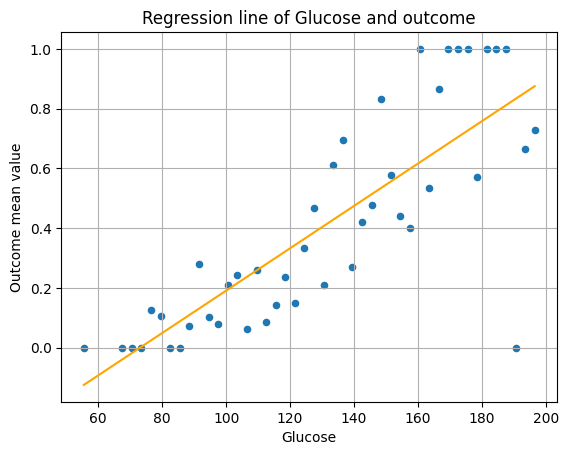

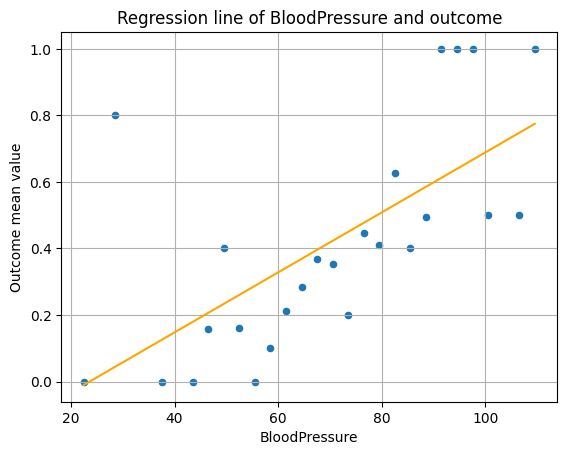

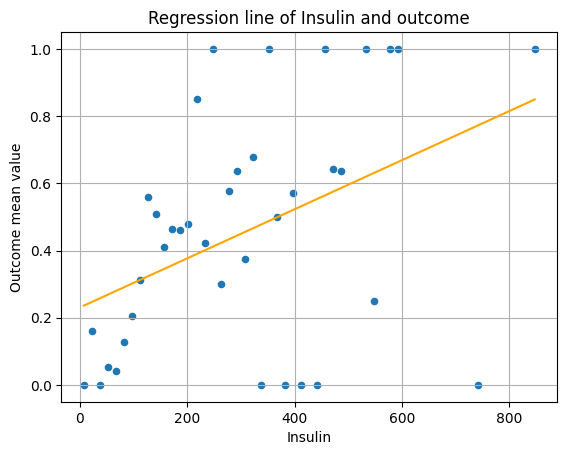

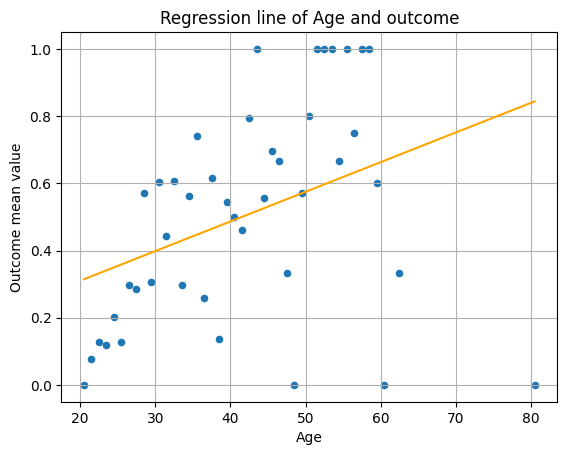

In [21]:
def show_regression_line(df: pd.DataFrame, name: str, bin_size: float | None) -> None:
    """
    Plot the dependent variable Outcome over independent variable df[name] and show a regression line.
    If the bin_size is not None, the Outcome values will be batched in bins and their mean value will be used
    """
    x = df[name]
    y = df['Outcome']
    
    # temporary group
    group_name = name + '_group'
    if bin_size is not None:
        # create bins for range [0, max_val + bin_size] of size bin_size
        bin_edges = np.arange(0, df[name].max() + bin_size, bin_size)
        
        # add temporary group
        df[group_name] = pd.cut(df[name], bins=bin_edges)
        
        # group the mean of the outcomes based on the range in the group
        y = df.groupby(group_name, observed=True)['Outcome'].mean()
        
        # select the middle value for plotting x value
        x = [interval.mid for interval in y.index]
        
    plt.scatter(x, y, s=20) 
    
    # build the regression line, using least squares method using polyfit numpy function
    slope, intercept = np.polyfit(x, y, 1)
    regression_line_values = np.array(x) * slope + intercept
    plt.plot(x, regression_line_values, color='orange')
    
    # remove temporary group
    df.drop(group_name, axis='columns', inplace=True)
    
    plt.grid()
    plt.xlabel(name)
    plt.ylabel('Outcome mean value')
    plt.title(f'Regression line of {name} and outcome')
    plt.show()
    
show_regression_line(data, 'Glucose', 3)
show_regression_line(data, 'BloodPressure', 3)
show_regression_line(data, 'Insulin', 15)
show_regression_line(data, 'Age', 1)

We can notice that outcome mean value has a positive correlation with the age until age ~50, after which it decreases significantly, making the slope of regression line negative. Either there is a nonlinear relationship, or I meade a mistake in plotting logic, because the correlation with age is positive (0.237).

## Building the model

In [22]:
# divide data into train and test sets
X = data.drop('Outcome', axis='columns')
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15) # 15% of data is for testing

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1030, 8) (1030,)
(182, 8) (182,)


In [23]:
reg = LinearRegression()
predictors = X_train.columns
# train the model
reg.fit(X_train[predictors], y_train)

LinearRegression()

In [24]:
y_pred = reg.predict(X_test)
y_pred

array([ 0.37246986,  0.53212818,  0.00439571,  0.00888395,  0.67576349,
        0.09816148,  0.48178912,  0.66223515,  0.76420306,  0.27568045,
        0.14151715,  0.36583082,  0.65922782, -0.0828443 ,  0.13829479,
        0.51127738,  0.22359473,  0.20258403, -0.08923754,  0.56509726,
        0.55896682,  0.21597194,  0.86144444,  0.68787961,  0.04308995,
        0.21450413,  0.54075399, -0.04114695,  0.75058666, -0.07164447,
        0.18275595,  0.19300878,  0.00360281,  0.23084667,  0.27463591,
        0.19243286,  0.05701392,  0.13773601,  0.93577497,  0.41869804,
        0.7656335 ,  0.36765034,  0.21036979, -0.27178369,  0.08250811,
        0.29393412,  0.39276522,  0.04398427,  1.07117078,  0.71562793,
        0.64254371,  0.06298491,  0.5125488 ,  0.67792221,  0.31023518,
        0.68171331,  0.4053803 ,  0.90162882,  0.35371837,  0.15805685,
        1.11101251,  1.00756867,  0.74660182,  0.10364343,  0.12653921,
        0.12653921,  0.18382828,  0.24887878,  0.34487045,  0.40

I got the chances of diabetes, but I need to predict only if yes or no

In [25]:
# round the predictions and make a series
y_pred = pd.Series(1 if v >= 0.5 else 0 for v in y_pred)
y_pred.name = 'Predictions'
y_pred

0      0
1      1
2      0
3      0
4      1
      ..
177    0
178    1
179    0
180    0
181    1
Name: Predictions, Length: 182, dtype: int64

## Compare predicted outcomes with actual outcomes

In [26]:
actual = X_test.copy()
actual['Outcome'] = y_test
actual

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
698,4,127,88,11,155,34.5,0.598,28,0
568,4,154,72,29,126,31.3,0.338,37,0
609,1,111,62,13,182,24.0,0.138,23,0
565,2,95,54,14,88,26.1,0.748,22,0
740,11,120,80,37,150,42.3,0.785,48,1
...,...,...,...,...,...,...,...,...,...
454,2,100,54,28,105,37.8,0.498,24,0
2296,6,154,78,41,140,46.1,0.571,27,0
1567,6,105,70,32,68,30.8,0.122,37,0
94,2,142,82,18,64,24.7,0.761,21,0


In [27]:
predicted = X_test.copy()
predicted['Prediction'] = y_pred
predicted

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Prediction
698,4,127,88,11,155,34.5,0.598,28,NaN
568,4,154,72,29,126,31.3,0.338,37,NaN
609,1,111,62,13,182,24.0,0.138,23,NaN
565,2,95,54,14,88,26.1,0.748,22,NaN
740,11,120,80,37,150,42.3,0.785,48,NaN
...,...,...,...,...,...,...,...,...,...
454,2,100,54,28,105,37.8,0.498,24,NaN
2296,6,154,78,41,140,46.1,0.571,27,NaN
1567,6,105,70,32,68,30.8,0.122,37,NaN
94,2,142,82,18,64,24.7,0.761,21,1.0


In [28]:
# let's see an overall description
y_pred.describe()

count    182.000000
mean       0.324176
std        0.469357
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Predictions, dtype: float64

In [29]:
error = mean_absolute_error(y_test, y_pred)
error

np.float64(0.2032967032967033)

In [30]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7967032967032966
Confusion Matrix:
 [[103  17]
 [ 20  42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       120
           1       0.71      0.68      0.69        62

    accuracy                           0.80       182
   macro avg       0.77      0.77      0.77       182
weighted avg       0.79      0.80      0.80       182



# Conclusion
Linear Regression machine learning is well suited for this task, since the dataset is relatively clean and normalized, not many steps were required for data preparation. My model is not very accurate, but it is satisfactory given the fact that it is my first modeling and data analysis project, I certainly missed a lot of steps or did some steps wrong. Anyway the model has an accuracy greater than 0.5 (~0.80) so it is on a correct way. Linear Regression was easy to understand and apply and I had no problems during the training.

#### Linear Regression
I understand this algorithm works like an interpolation using a multivariate function found using the mathematical linear regression function model. During the training, the model adapts its parameters to fit the multidimensional regression line to best fit the outcomes on the input.

#### Scikit
This library contains a tremendous amount of useful functions and algorithms for model training, and is very well documented.

#### pandas
I found this library very convenient to work with the datasets. Row, columns and series manipulations are very useful and performant. My favorite feature was corr function that returns the correlation of a variable with all other variables in the dataset.

#### Time taken
~5 hr

# Bibliography
- [Diagnosing Diabetes with Machine Learning Techniques](https://dergipark.org.tr/en/download/article-file/1970853#:~:text=The%20'DiabetesPedigreeFunction'%20is%20a%20function,1%20represents%20those%20with%20diabetes.)
- [Build Your First Machine Learning Project \[Full Beginner Walkthrough\]](https://www.youtube.com/watch?v=Hr06nSA-qww)
- [Diabetes Predicion Using Logistic Regression](https://www.kaggle.com/code/nanditapore/diabetes-predicion-using-logistic-regression)
- [Correlation](https://brilliant.org/wiki/correlation/)
- [Linear regression](https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/simple-linear-regression.html)